In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

Mounted at /content/drive


In [2]:
import tensorflow as tf
import keras 
from tensorflow.keras import backend as K
import itertools
from tensorflow.keras.layers import Flatten, Conv2D, Concatenate, MaxPooling2D, ZeroPadding2D, concatenate, Input, Reshape, GlobalAveragePooling2D, Dense, Dropout, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D

### helper functions

In [11]:
#%%# define custom function for confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
''' calibrated categorical focal loss'''

def categorical_focal_loss_fixed(y_true, y_pred, alpha = 1.0, gamma = 2.0):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))  

### training

In [60]:
img_width, img_height = 224,224
train_data_dir = "/content/drive/MyDrive/Inbrest-dataset/train"
test_data_dir = "/content/drive/MyDrive/Inbrest-dataset/test"
val_data_dir = "/content/drive/MyDrive/Inbrest-dataset/valid"
epochs = 64 
batch_size = 22
num_classes = 2 # normal, abnormal
input_shape = (img_width, img_height, 3)
model_input = Input(shape=input_shape)
print(model_input) 

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [61]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#define data generators
datagen = ImageDataGenerator(
                            rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest',
                            rescale=1./255,
                            validation_split=0.1) 

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        seed=42,
        batch_size=batch_size, 
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        seed=42,
        batch_size=batch_size, 
        class_mode='categorical')

test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
         shuffle = False,
        batch_size=batch_size, 
        class_mode='categorical')

Found 173 images belonging to 2 classes.
Found 23 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [63]:
#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

#check the class indices
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)


{'abnormal': 0, 'normal': 1}
{'abnormal': 0, 'normal': 1}
{'abnormal': 0, 'normal': 1}


In [64]:
from tensorflow.keras.utils import to_categorical
#true labels
Y_val=validation_generator.classes
print(Y_val.shape)

Y_test=test_generator.classes
print(Y_test.shape)

Y_test1=to_categorical(Y_test, num_classes=num_classes, dtype='float32')
print(Y_test1.shape)

(23,)
(18,)
(18, 2)


In [65]:
#compute class weights to penalize over represented classes
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))

print(class_weights)

{0: 1.005813953488372, 1: 0.9942528735632183}


Load the Resnet34-based U-Net model and truncate at the decoder_stage4b_conv layer and 
add classification layers

In [163]:
from tensorflow.keras.models import Model,load_model
model = load_model('/content/drive/MyDrive/Segmentation_model/resenet_unet_segmentation.hdf5',
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
# model.trainable = False
# model.summary()
base_model=Model(inputs=model.input,
                        outputs=model.get_layer('decoder_stage4b_conv').output)
x = base_model.output 
x = ZeroPadding2D()(x)
x = Conv2D(32,(3,3), activation='relu', name = 'extra_conv_resnet') (x)
x = GlobalAveragePooling2D()(x) 
logits = Dense(2, 
              activation='softmax', 
              name='predictions')(x)

In [164]:
model_resnet = Model(inputs=base_model.input, 
                    outputs=logits, 
                    name = 'resnet_pretrained')

model_resnet.summary()

Model: "resnet_pretrained"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                

## Training  loss=categorical_focal_loss_fixed

In [165]:
#%% train each model
from tensorflow.keras.optimizers import SGD, RMSprop,Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)  
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    amsgrad=True)
# dcakld_loss - dcahinge_loss - categorical_focal_loss_fixed 
# dcafocal_loss - entropy_loss - dcaentropy_loss - regularizer -categorical_focal_loss
# smoothcce02 - smoothfocal
model_resnet.compile(optimizer=sgd, 
                    loss= categorical_focal_loss_fixed, run_eagerly=True,  #use other losses in the same way
                    metrics=['accuracy']) 
#%%
#begin training
filepath = '/content/drive/MyDrive/weights/' + model_resnet.name + 'categorical_focal_loss_fixed.{epoch:02d}-{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=True, 
                             mode='max', 
                             save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              patience=40, 
                              verbose=1, 
                              mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=5,
                              verbose=1,
                              mode='max')
callbacks_list = [checkpoint]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [166]:
#reset generators
train_generator.reset()
validation_generator.reset()

#train the model
model_resnet_history = model_resnet.fit(train_generator, 
                                      steps_per_epoch=nb_train_samples // batch_size,
                                      epochs=100, 
                                      validation_data=validation_generator,
                                      callbacks=callbacks_list, 
                                      class_weight = class_weights,
                                      validation_steps=nb_validation_samples // batch_size, 
                                      verbose=1)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.5430
Epoch 1: val_accuracy improved from -inf to 0.59091, saving model to /content/drive/MyDrive/weights/resnet_pretrainedcategorical_focal_loss_fixed.01-0.5909.h5
7/7 [==============================] - 33s 5s/step - loss: 0.3230 - accuracy: 0.5430 - val_loss: 0.1895 - val_accuracy: 0.5909
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.5099
Epoch 2: val_accuracy did not improve from 0.59091
7/7 [==============================] - 29s 4s/step - loss: 0.1895 - accuracy: 0.5099 - val_loss: 0.2177 - val_accuracy: 0.4545
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.5779
Epoch 3: val_accuracy did not improve from 0.59091
7/7 [==============================] - 29s 4s/step - loss: 0.1754 - accuracy: 0.5779 - val_loss: 0.1770 - val_accuracy: 0.5455
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.1675 - acc

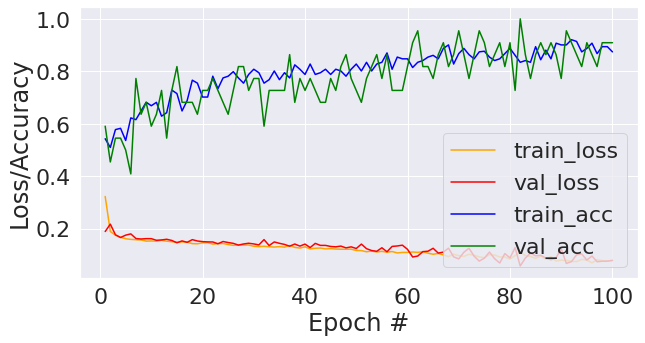

In [167]:
N = 100 #epochs; change if early stopping

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, N+1), 
         model_resnet_history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), 
         model_resnet_history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), 
         model_resnet_history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), 
         model_resnet_history.history["val_accuracy"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")

In [169]:
test_generator.reset() 
custom_y_pred = model_resnet.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)
custom_y_pred1_label = custom_y_pred.argmax(axis=-1)

#%%
#save predictions to a CSV file

predicted_class_indices=np.argmax(custom_y_pred,axis=1)
print(predicted_class_indices)

'''
map the predicted labels with their unique ids such 
as filenames to find out what you predicted for which image.
'''

labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#save the results to a CSV file
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predicted_class_indices,
                      "Labels":predictions})
# results.to_csv("performance/resnet_cce.csv",index=False)

1/1 [==============================] - 3s 3s/step
[0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1]


In [170]:
results

,Filename,Predictions,Labels
0,abnormal/20588536.png,0,abnormal
1,abnormal/22580341.png,0,abnormal
2,abnormal/22670278.png,0,abnormal
3,abnormal/22670465.png,0,abnormal
4,abnormal/22670855.png,0,abnormal
5,abnormal/24055502.png,0,abnormal
6,abnormal/24065761.png,1,normal
7,abnormal/53580858.png,0,abnormal
8,abnormal/53586960.png,0,abnormal
9,normal/22679036.png,1,normal


              precision    recall  f1-score   support

    abnormal     1.0000    0.8889    0.9412         9
      Normal     0.9000    1.0000    0.9474         9

    accuracy                         0.9444        18
   macro avg     0.9500    0.9444    0.9443        18
weighted avg     0.9500    0.9444    0.9443        18



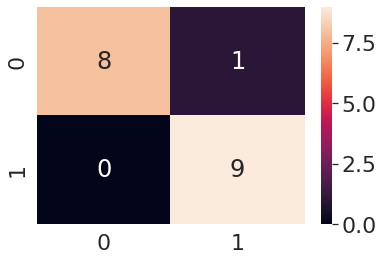

In [171]:
import seaborn as sns
from sklearn.metrics import f1_score, cohen_kappa_score, precision_score, recall_score, classification_report, log_loss, confusion_matrix, accuracy_score 
from sklearn.utils import class_weight
target_names = ['abnormal','Normal']
print(classification_report(Y_test1.argmax(axis=-1),
                            custom_y_pred.argmax(axis=-1),
                            target_names=target_names, 
                            digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),
                              custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=5)

sns.set(font_scale=2)
b = sns.heatmap(cnf_matrix, annot=True)

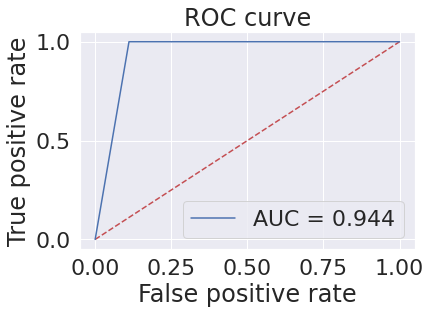

In [172]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(Y_test1.argmax(axis=-1),
                              custom_y_pred.argmax(axis=-1))
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test1.argmax(axis=-1),
                              custom_y_pred.argmax(axis=-1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()